In [18]:
# Import the library needed for training first

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import InputLayer, Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import os

In [2]:
batch_size = 128 #
num_classes = 10
epochs = 1 

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 3s 1us/step


In [3]:
# different backend saves data in diffferent format

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
else: # for Tensorflow, the format is [N_image, image_row, image_col, channel]
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize the pixels to [0, 1]
X_train /= 255
X_test /= 255

# subset 5000 samples from X_train as validation_set
# The validation set is used for further network tuning, while the test set is only used to assess the accuracy of the model
# Commonly used percentages are 5%, 80%, 15%

X_train, X_val = X_train[0:55000,:,:,:], X_train[-5000:,:,:,:]
y_train, y_val = y_train[0:55000], y_train[-5000:]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_val.shape[0], 'validation samples')

X_train shape: (55000, 28, 28, 1)
55000 train samples
10000 test samples
5000 validation samples


In [4]:
# convert class vectors to one-hot class matrices

y_train_vec = y_train
y_test_vec = y_test
y_val_vec = y_val
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

Select the first 9 images


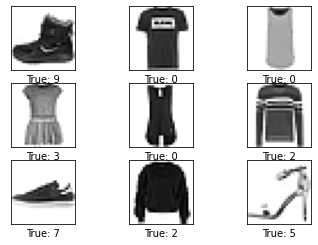

In [9]:
# check some of images to see if the data is loaded correctly

def plot_images(images, label, pred=None):
    if pred is None:
        try:
            assert images.shape[0] == len(label) == 9
        except AssertionError:
            images = images[0:9,:,:,:]
            label = label[0:9]
            print('Select the first 9 images')
    else:
        try:
            assert images.shape[0] == len(label) == len(pred) == 9
        except AssertionError:
            images = images[0:9,:,:,:]
            label = label[0:9]
            pred = pred[0:9]
            print('Select the first 9 images')
            
    fig, axes = plt.subplots(3,3)
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape([img_rows, img_cols]), cmap='binary')
        # Show true and predicted classes
        if pred is None:
            xlabel = "True: %d" % label[i]
        else:
            xlabel = "True: %d, Pred: %d" % (label[i], pred[i])
        ax.set_xlabel(xlabel)
        # Show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])   
    plt.show()
    
plot_images(X_train, y_train_vec)

In [10]:
# plot the incorrectly predicted images 

def plot_example_errors(images, label, pred):
    # Boolean array whether the predicted class is incorrect.
    incorrect = (label != pred)
    # subset the images and labels
    images = images[incorrect,:,:,:]
    label = label[incorrect]
    pred = pred[incorrect]
    plot_images(images, label, pred)

In [11]:
# define the save path for the trained_model
save_path = './trained_model'
save_file = 'cnn_mnist.keras'
# check if the save_path exists
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [13]:
learning_rate = 1e-3
model = Sequential()
# input layer
model.add(InputLayer(input_shape=(img_rows, img_cols, 1, )))
model.add(Conv2D(32, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_1'))
model.add(Conv2D(64, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_2'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

In [14]:
model.summary()
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv_1 (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
layer_conv_2 (Conv2D)        (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                802880    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 822,346
Trainable params: 822,346
Non-trainable params: 0
________________________________________________

Model saved


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Select the first 9 images


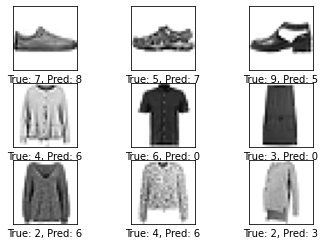

In [15]:
# save the model
model_path = os.path.join(save_path, save_file)
model.save(model_path)
print('Model saved')
# for model reuse in the future, use the following commands
#from keras.models import load_model
#model = load_model(model_path)

# for further investigation, return the label of the test set
y_pred = model.predict_classes(x=X_test)
plot_example_errors(X_test, y_test_vec, y_pred)

In [ ]:
# The main framework of the model comes from：
# https://github.com/air-y/pythontrain_cnn/blob/master/MNIST_cnn_ori.py
# Next, I'll be tuning the Fashion MNIST dataset to see how each step affects the accuracy of the model

In [16]:
# The training results found that the accuracy was only about 88%, 
# Which is much worse than the accuracy of the MNIST dataset

# First, I just change epochs from 1 to 10

X_train shape: (55000, 28, 28, 1)
55000 train samples
10000 test samples
5000 validation samples
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv_1 (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
layer_conv_2 (Conv2D)        (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                802880    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 822,346


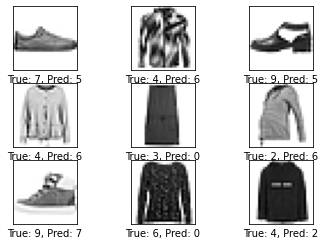

In [26]:
batch_size = 128 
num_classes = 10
epochs = 10 

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


# different backend saves data in diffferent format
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
else: # for Tensorflow, the format is [N_image, image_row, image_col, channel]
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize the pixels to [0, 1]
X_train /= 255
X_test /= 255

# subset 5000 samples from X_train as validation_set
X_train, X_val = X_train[0:55000,:,:,:], X_train[-5000:,:,:,:]
y_train, y_val = y_train[0:55000], y_train[-5000:]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_val.shape[0], 'validation samples')


# convert class vectors to one-hot class matrices
y_train_vec = y_train
y_test_vec = y_test
y_val_vec = y_val
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)



# define the save path for the trained_model
save_path = './trained_model'
save_file = 'cnn_mnist.keras'
# check if the save_path exists
if not os.path.exists(save_path):
    os.mkdir(save_path)


learning_rate = 1e-3
model = Sequential()
# input layer
model.add(InputLayer(input_shape=(img_rows, img_cols, 1, )))
model.add(Conv2D(32, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_1'))
model.add(Conv2D(64, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_2'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

model.summary()
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# save the model
model_path = os.path.join(save_path, save_file)
model.save(model_path)
print('Model saved')
# for model reuse in the future, use the following commands
#from keras.models import load_model
#model = load_model(model_path)

# for further investigation, return the label of the test set
y_pred = model.predict_classes(x=X_test)
plot_example_errors(X_test, y_test_vec, y_pred)

In [ ]:
# With only the epoch change, there was a relatively large improvement in the correct rate, to 91%. 
# However, after testing, 
# it was found that continuing to increase the epoch again did not improve as much as this

In [ ]:
# Next 
# added Dropout 
# changed the Batch size
# added MaxPooling

In [25]:
batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


# different backend saves data in diffferent format
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
else: # for Tensorflow, the format is [N_image, image_row, image_col, channel]
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize the pixels to [0, 1]
X_train /= 255
X_test /= 255

# subset 5000 samples from X_train as validation_set
X_train, X_val = X_train[0:55000,:,:,:], X_train[-5000:,:,:,:]
y_train, y_val = y_train[0:55000], y_train[-5000:]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_val.shape[0], 'validation samples')


# convert class vectors to one-hot class matrices
y_train_vec = y_train
y_test_vec = y_test
y_val_vec = y_val
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)


# define the save path for the trained_model
save_path = './trained_model'
save_file = 'cnn_mnist.keras'
# check if the save_path exists
if not os.path.exists(save_path):
    os.mkdir(save_path)


learning_rate = 1e-3
model = Sequential()
# input layer
model.add(InputLayer(input_shape=(img_rows, img_cols, 1, )))
from keras.layers.normalization import BatchNormalization

model.add(Conv2D(32, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_1'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_2'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#dropout it
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
#dropout it
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# save the model
model_path = os.path.join(save_path, save_file)
model.save(model_path)

# for model reuse in the future, use the following commands
#from keras.models import load_model
#model = load_model(model_path)

X_train shape: (55000, 28, 28, 1)
55000 train samples
10000 test samples
5000 validation samples
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv_1 (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
layer_conv_2 (Conv2D)        (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)              0         
_______________________

In [ ]:
# Adding the dropout layer alone without increasing the epoch has been shown to decrease accuracy, 
# but with an increase in epoch, the accuracy can be further improved.
# Indicates that a dropout is not required if the model is not overfitted

In [27]:
batch_size = 36
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


# different backend saves data in diffferent format
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
else: # for Tensorflow, the format is [N_image, image_row, image_col, channel]
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize the pixels to [0, 1]
X_train /= 255
X_test /= 255

# subset 5000 samples from X_train as validation_set
X_train, X_val = X_train[0:55000,:,:,:], X_train[-5000:,:,:,:]
y_train, y_val = y_train[0:55000], y_train[-5000:]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_val.shape[0], 'validation samples')


# convert class vectors to one-hot class matrices
y_train_vec = y_train
y_test_vec = y_test
y_val_vec = y_val
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)


# define the save path for the trained_model
save_path = './trained_model'
save_file = 'cnn_mnist.keras'
# check if the save_path exists
if not os.path.exists(save_path):
    os.mkdir(save_path)


learning_rate = 1e-3
model = Sequential()
# input layer
model.add(InputLayer(input_shape=(img_rows, img_cols, 1, )))
from keras.layers.normalization import BatchNormalization

model.add(Conv2D(32, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_1'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_2'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#dropout it
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
#dropout it
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# save the model
model_path = os.path.join(save_path, save_file)
model.save(model_path)

# for model reuse in the future, use the following commands
#from keras.models import load_model
#model = load_model(model_path)

X_train shape: (55000, 28, 28, 1)
55000 train samples
10000 test samples
5000 validation samples
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv_1 (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
layer_conv_2 (Conv2D)        (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3136)              0         
______________________

In [ ]:
# After adding epoch, dropout layer and pooling layer, 
# the accuracy is significantly improved compared to the original one.